In [1]:
# -----------------------------
# Cell 1: Setup paths
# -----------------------------
import sys
from pathlib import Path

# Notebook location
notebook_path = Path().resolve()  # current notebook folder
project_root = notebook_path.parent.parent  # Notebook/ -> project root
src_path = project_root / "src"


# Current notebook folder
notebook_path = Path().resolve()


# Add to Python path
sys.path.insert(0, str(src_path))
sys.path.insert(0, str(project_root))

print("Notebook path:", notebook_path)
print("Project root:", project_root)
print("SRC path:", src_path)

Notebook path: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\notebooks\analysis
Project root: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics
SRC path: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\src


In [2]:
import pandas as pd
import logging
import seaborn as sns

# Custom imports
from fintech_app_reviews.config import load_config
from fintech_app_reviews.viz.plots import (plot_ratings_per_bank,
                                               plot_sentiment_per_bank,
                                           plot_theme_distribution, plot_monthly_sentiment)
from fintech_app_reviews.viz.wordcloud_gen import plot_wordcloud

# Setup logging

logging.basicConfig(level=logging.INFO,
format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger(__name__)

In [3]:
# Config path at project root
config_path = project_root / "configs" / "nlp.yaml"

# Load NLP config
nlp_cfg = load_config(config_path)


output_path = project_root / \
    nlp_cfg["output"].get(
        "themes_path")
    
print("Output path:", output_path) 

df = pd.read_csv(output_path )

df["txt_clean"] = df["txt_clean"].fillna("")
df["bank"] = df["bank"].fillna("Unknown")

# Quick check
df.head(3)
    

Output path: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\data\processed\reviews_with_themes.csv


,review,rating,date,bank,source,review_id,txt_clean,hf_label,hf_score,hf_score_signed,sentiment_score,sentiment_label,keywords,themes,theme_primary,theme_secondary,all_themes
0,it's special for me,5,2025-11-29,Commercial Bank of Ethiopia (CBE),google_play,1,special,positive,0.999722,0.999722,0.999722,positive,NaN,[],NaN,NaN,NaN
1,this application is very important and advanta...,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,2,application important advantage transfer money...,positive,0.732493,0.732493,0.732493,positive,money|transfer|application,['Transaction Performance'],Transaction Performance,NaN,Transaction Performance
2,why didn't work this app?,1,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,3,work app,positive,0.978127,0.978127,0.978127,positive,app|work,[],NaN,NaN,NaN


In [4]:
theme_stats = df.groupby(["bank", "theme_primary"]).agg(
    avg_sentiment=("sentiment_score", "mean"),
    count=("review_id", "count")
).reset_index()
theme_stats.sort_values(["bank", "avg_sentiment"], ascending=[
                        True, False], inplace=True)
theme_stats.head(10)

,bank,theme_primary,avg_sentiment,count
0,Bank of Abyssinia (BOA),Customer Support,0.580896,10
3,Bank of Abyssinia (BOA),User Interface / UX,-0.586423,5
1,Bank of Abyssinia (BOA),Feature Requests,-0.636534,22
2,Bank of Abyssinia (BOA),Transaction Performance,-0.751772,38
4,Commercial Bank of Ethiopia (CBE),Customer Support,-0.054869,15
5,Commercial Bank of Ethiopia (CBE),Feature Requests,-0.259705,19
6,Commercial Bank of Ethiopia (CBE),Transaction Performance,-0.319447,9
7,Commercial Bank of Ethiopia (CBE),User Interface / UX,-0.999803,1
11,Dashen Bank,User Interface / UX,0.999572,5
9,Dashen Bank,Feature Requests,0.436264,28


In [5]:
theme_summary = df.groupby(["bank", "theme_primary"]
                           ).size().reset_index(name="count")
theme_summary = theme_summary.merge(
    df.groupby(["bank", "theme_primary"]).sentiment_score.mean(
    ).reset_index(name="avg_sentiment"),
    on=["bank", "theme_primary"]
)
theme_summary["pct"] = theme_summary.groupby(
    "bank")["count"].transform(lambda x: 100 * x / x.sum())

drivers = theme_summary[(theme_summary.avg_sentiment >
                         0.2) & (theme_summary.pct > 5)]
pain_points = theme_summary[(
    theme_summary.avg_sentiment < -0.1) & (theme_summary.pct > 5)]

print("Drivers per bank:\n", drivers)
print("Pain points per bank:\n", pain_points)

Drivers per bank:
                        bank        theme_primary  count  avg_sentiment  \
0   Bank of Abyssinia (BOA)     Customer Support     10       0.580896   
8               Dashen Bank     Customer Support      9       0.329470   
9               Dashen Bank     Feature Requests     28       0.436264   
11              Dashen Bank  User Interface / UX      5       0.999572   

          pct  
0   13.333333  
8   14.285714  
9   44.444444  
11   7.936508  
Pain points per bank:
                                  bank            theme_primary  count  \
1             Bank of Abyssinia (BOA)         Feature Requests     22   
2             Bank of Abyssinia (BOA)  Transaction Performance     38   
3             Bank of Abyssinia (BOA)      User Interface / UX      5   
5   Commercial Bank of Ethiopia (CBE)         Feature Requests     19   
6   Commercial Bank of Ethiopia (CBE)  Transaction Performance      9   
10                        Dashen Bank  Transaction Performance     21

2025-12-03 12:58:07,610 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-03 12:58:07,634 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


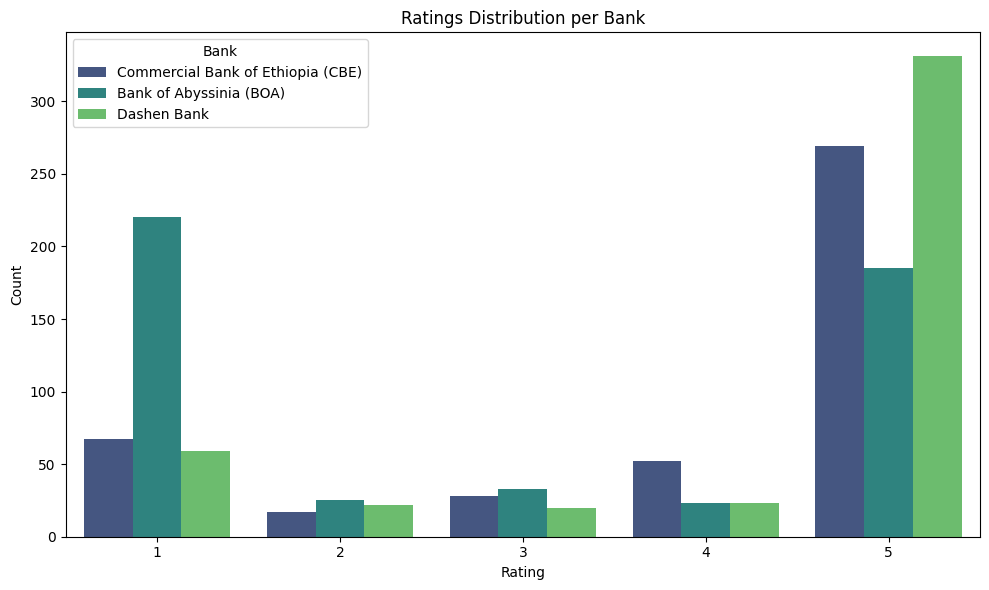

D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\src\fintech_app_reviews\viz\plots.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=bank_col, y=score_col, palette=palette)


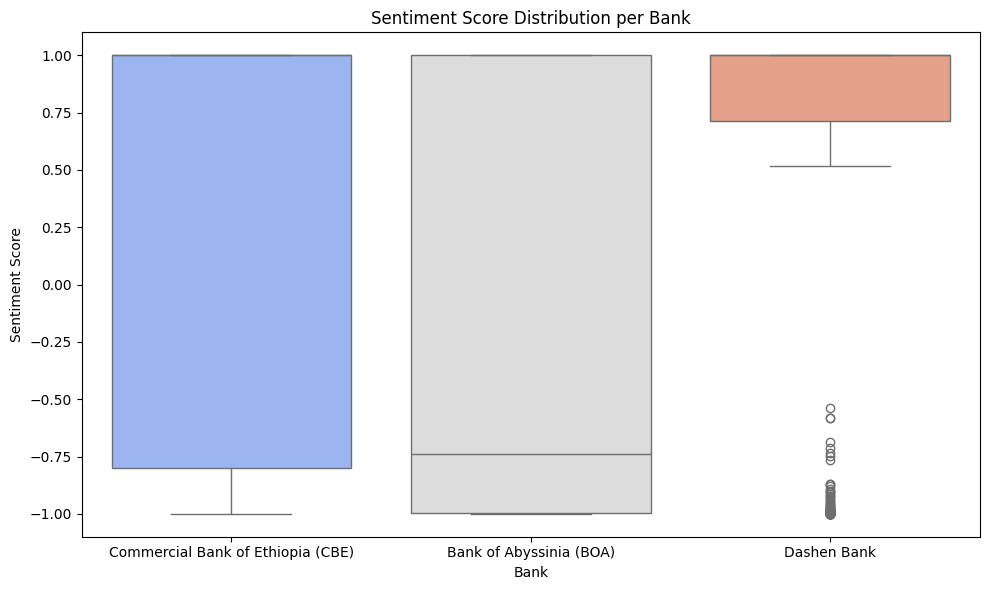

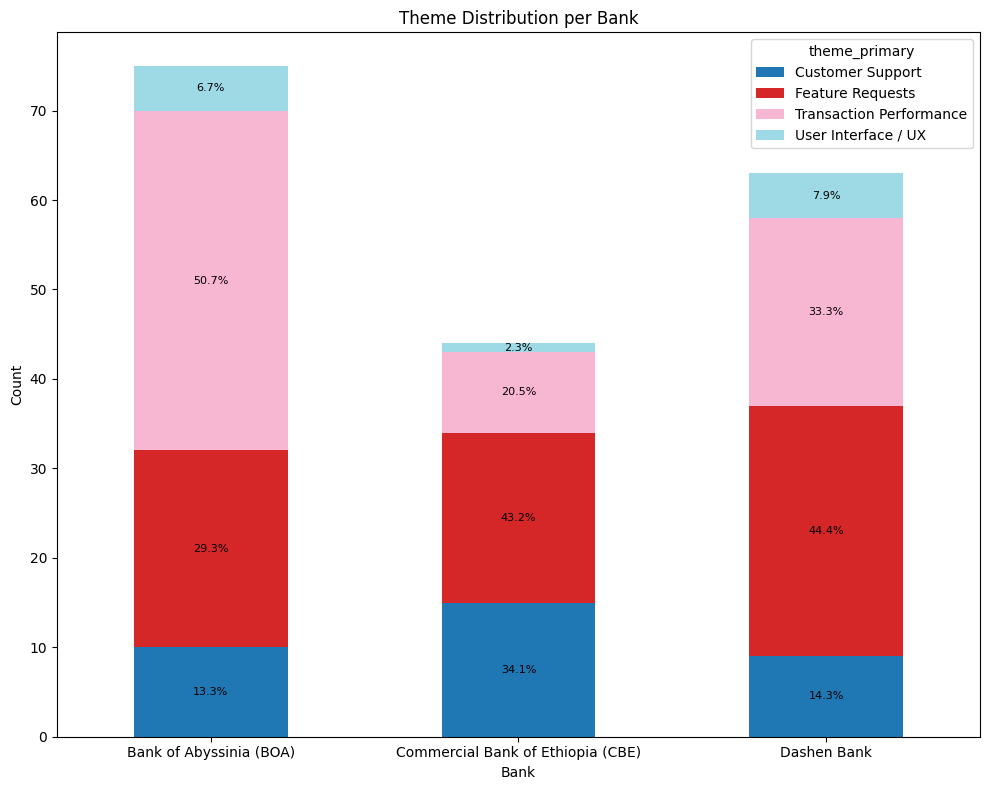

In [6]:
plot_ratings_per_bank(df)
plot_sentiment_per_bank(df)
plot_theme_distribution(df)

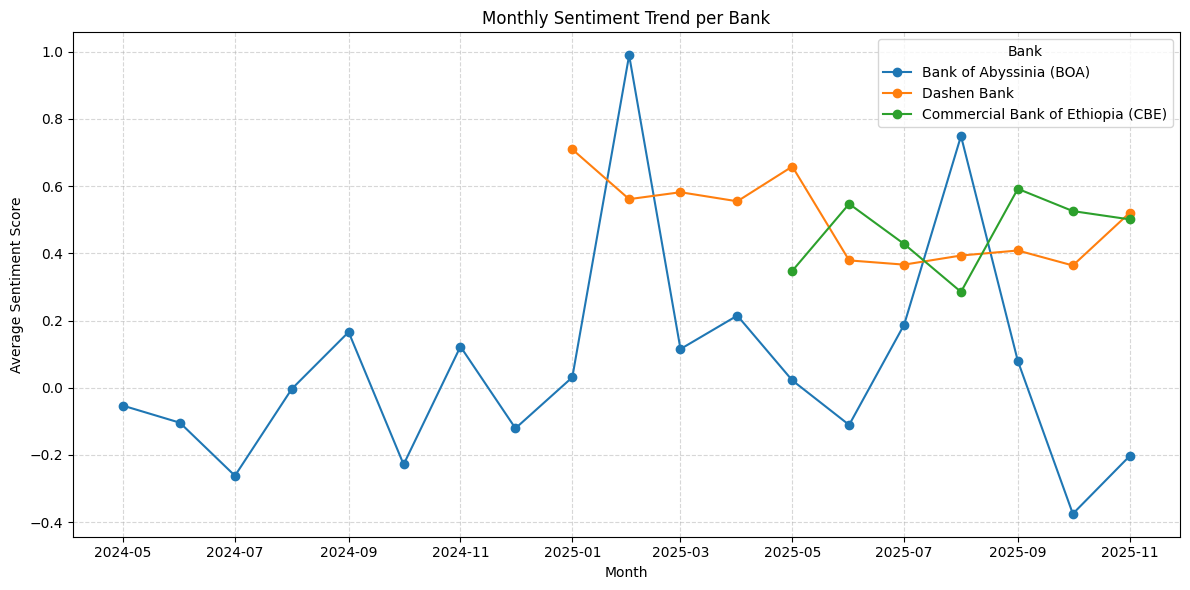

In [7]:
plot_monthly_sentiment(df)

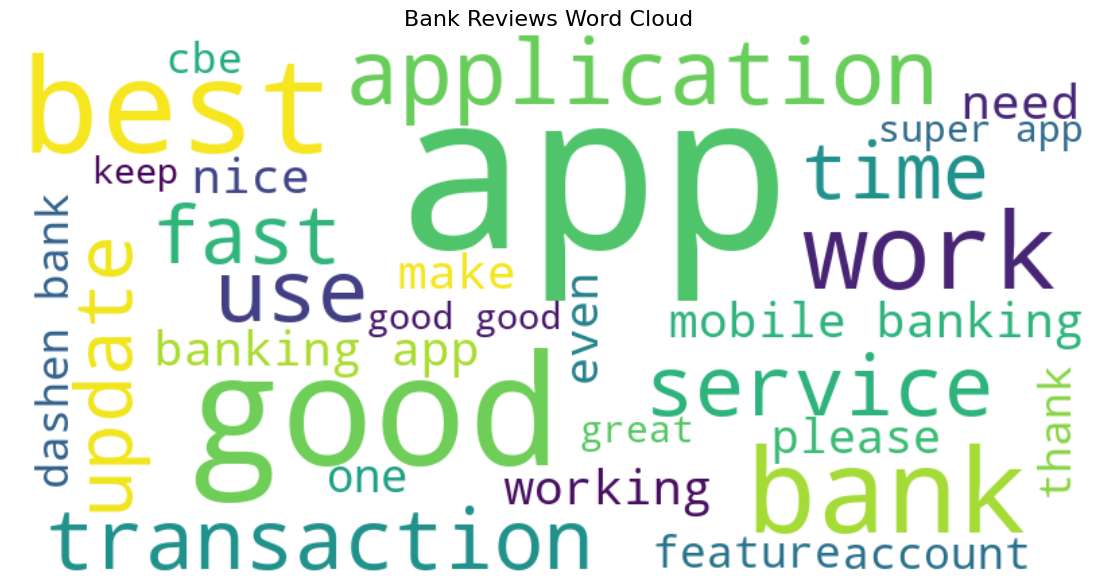

In [8]:
plot_wordcloud(df['txt_clean'].tolist(), max_words=30,
               title="Bank Reviews Word Cloud")

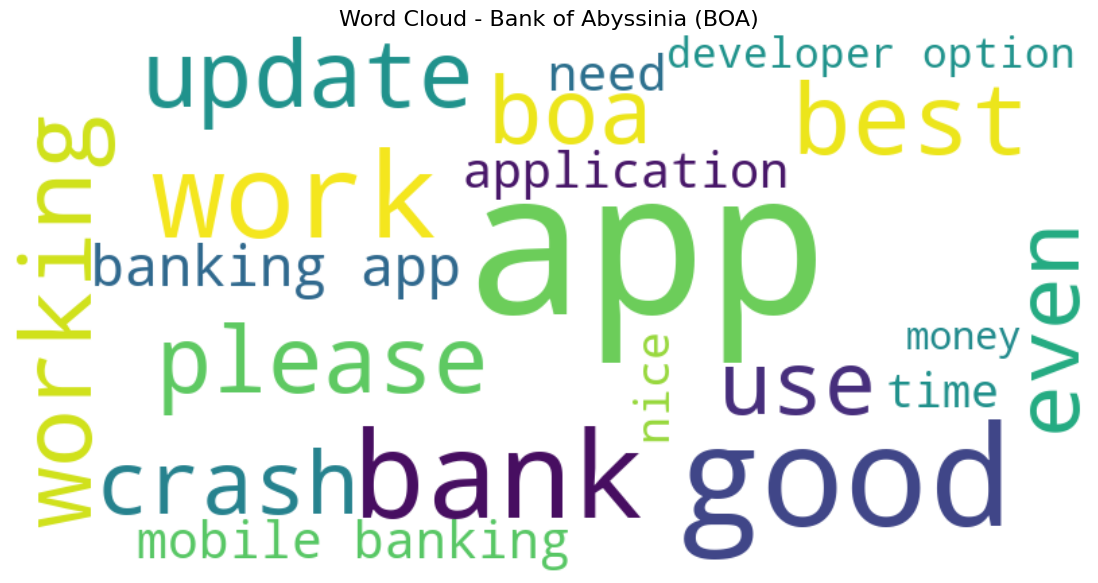

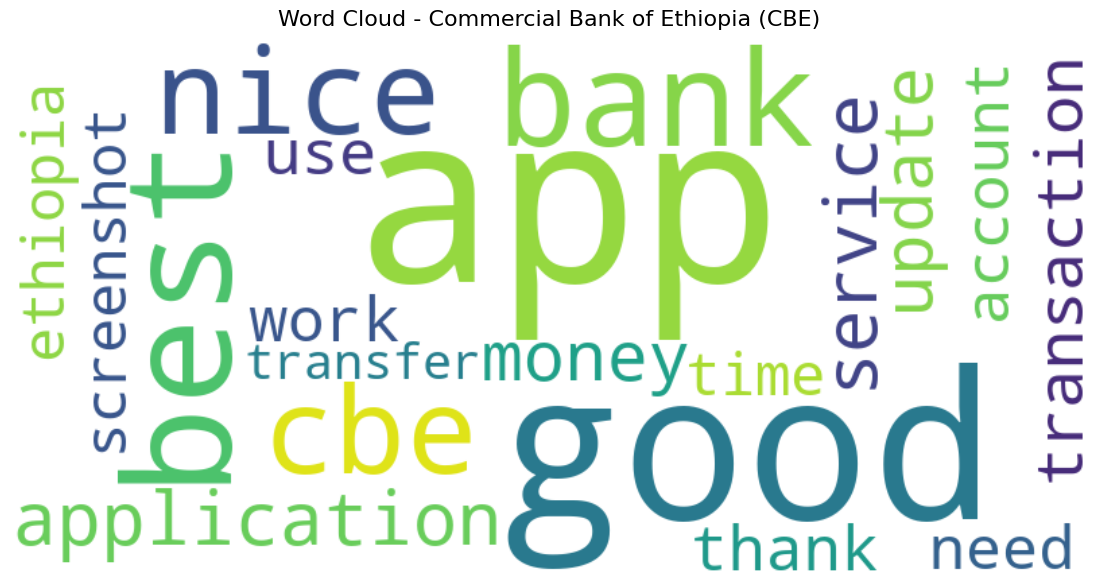

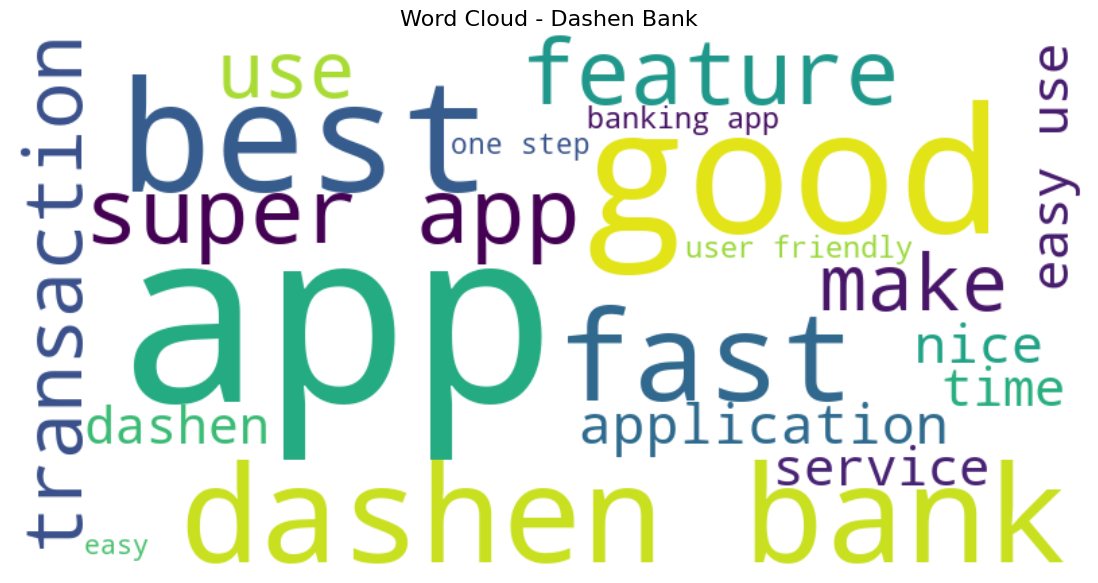

In [9]:
for bank, gdf in df.groupby("bank"):
    plot_wordcloud(
        gdf["txt_clean"].tolist(),
        max_words=20,
        title=f"Word Cloud - {bank}"
    )